In [16]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openai
from openai import OpenAI

In [10]:
df = pd.read_csv('label_output_copy.csv')
df.drop(columns=['image_id'], inplace=True)
df

,label,output
0,iption: x-ray chest frontal and lateral cl...,NaN
1,no acute findings.,no definite acute abnormality.
2,cardiomegaly with moderate interstitial edema.,NaN
3,mild left basilar opacity in setting of decrea...,no definite acute abnormality.
4,no acute cardiopulmonary or osseous abnormality.,no definite acute abnormality.
...,...,...
2238,enlarged cardiac silhouette with interstitial ...,NaN
2239,no acute cardiopulmonary abnormality. previous...,no definite acute abnormality.
2240,no acute cardiopulmonary findings and no convi...,NaN
2241,no radiographic evidence of acute cardiopulmon...,no definite acute abnormality.


In [11]:
# df['output'].isnull().sum()
df['label'].str.split().str.len().mean() # avg number of tokens per report
# df['label'][92]


19.809629959875167

### Call GPT3.5 Turbo API

In [26]:
# get all disease entities in one prompt
diseases = {
    'pneumothorax': ['none', 'small', 'medium', 'large'],
    'pneumonia': ['none', 'possible', 'definite'],
    'pleural effusion': ['none', 'small', 'medium', 'large'],
    'cardiomegaly': ['none', 'mild', 'severe'],
    'edema': ['none', 'mild', 'severe'],
    'rib fracture': ['none', 'present']
}
disease_classifications = {disease: [] for disease in diseases}

questions = []
for disease, scales in diseases.items():
    scale_str = ', '.join(scales)
    questions.append(f"Determine the severity of {disease}: {scale_str}.")
questions_str = ' '.join(questions)
questions_str

'Determine the severity of pneumothorax: none, small, medium, large. Determine the severity of pneumonia: none, possible, definite. Determine the severity of pleural effusion: none, small, medium, large. Determine the severity of cardiomegaly: none, mild, severe. Determine the severity of edema: none, mild, severe. Determine the severity of rib fracture: none, present.'

In [159]:
# Testing
client = OpenAI(api_key='')
report = 'no definite acute abnormality.'

response = client.chat.completions.create(
  model="gpt-3.5-turbo-0125",
  messages=[
    {"role": "system", "content": "You are a helpful assistant designed to parse medical reports."},
    {"role": "user", "content": f"Given this report: '{report}' {questions_str} Answer each classification in one word."}
  ]
)
print(response.choices[0].message.content)
response_content = response.choices[0].message.content

- Pneumothorax: none
- Pneumonia: none
- Pleural effusion: none
- Cardiomegaly: none
- Edema: none
- Rib fracture: none


In [168]:
pd.isnull(df['output'][0])

True

In [17]:
client = OpenAI(api_key='')

def get_classifications(df, col, diseases):
  # formulate prompt
  diseases = {
    'pneumothorax': ['none', 'small', 'medium', 'large'],
    'pneumonia': ['none', 'possible', 'definite'],
    'pleural effusion': ['none', 'small', 'medium', 'large'],
    'cardiomegaly': ['none', 'mild', 'severe'],
    'edema': ['none', 'mild', 'severe'],
    'rib fracture': ['none', 'present']
  }
  classifications = []

  questions = []
  for disease, scales in diseases.items():
    scale_str = ', '.join(scales)
    questions.append(f"Determine the severity of {disease}: {scale_str}.")
  questions_str = ' '.join(questions)

  # API call for each report
  for report in df[col]:
    if pd.isnull(report):
      classifications.append('pneumothorax: none\npneumonia: none\npleural effusion: none\ncardiomegaly: none\nedema: none\nrib fracture: none')
    else:
      response = client.chat.completions.create(
        model="gpt-3.5-turbo-0125",
        messages=[
          {"role": "system", "content": "You are a helpful assistant designed to parse medical reports."},
          {"role": "user", "content": f"Given this report: {report} {questions_str} Answer each classification in one word."}
        ]
      )
      classifications.append(response.choices[0].message.content)

  return classifications

##### Call API on medical reports - ground truth

In [91]:
# label_classifications = get_classifications(df, 'label', diseases)
# label_classifications

['Severity of pneumothorax: none\nSeverity of pneumonia: none\nSeverity of pleural effusion: none\nSeverity of cardiomegaly: none\nSeverity of edema: none\nSeverity of rib fracture: present',
 'Pneumothorax: none\nPneumonia: none\nPleural effusion: none\nCardiomegaly: none\nEdema: none\nRib fracture: none',
 '- Pneumothorax: none\n- Pneumonia: possible\n- Pleural effusion: none\n- Cardiomegaly: moderate\n- Edema: moderate\n- Rib fracture: none',
 'Pneumothorax: none\nPneumonia: possible\nPleural effusion: none\nCardiomegaly: none\nEdema: none\nRib fracture: none',
 '- Pneumothorax: none\n- Pneumonia: none\n- Pleural effusion: none\n- Cardiomegaly: none\n- Edema: none\n- Rib fracture: none',
 'Severity of pneumothorax: small\n\nSeverity of pneumonia: possible\n\nSeverity of pleural effusion: small\n\nSeverity of cardiomegaly: mild\n\nSeverity of edema: none\n\nSeverity of rib fracture: present',
 'Pneumothorax: None  \nPneumonia: None  \nPleural effusion: None  \nCardiomegaly: None  \nE

In [22]:
df = pd.read_csv('model1_label_classification.csv', index_col=0)
df

,label,output,label_classifications
0,iption: x-ray chest frontal and lateral cl...,NaN,Severity of pneumothorax: none\nSeverity of pn...
1,no acute findings.,no definite acute abnormality.,Pneumothorax: none\nPneumonia: none\nPleural e...
2,cardiomegaly with moderate interstitial edema.,NaN,- Pneumothorax: none\n- Pneumonia: possible\n-...
3,mild left basilar opacity in setting of decrea...,no definite acute abnormality.,Pneumothorax: none\nPneumonia: possible\nPleur...
4,no acute cardiopulmonary or osseous abnormality.,no definite acute abnormality.,- Pneumothorax: none\n- Pneumonia: none\n- Ple...
...,...,...,...
2238,enlarged cardiac silhouette with interstitial ...,NaN,Pneumothorax: Small \nPneumonia: Possible \n...
2239,no acute cardiopulmonary abnormality. previous...,no definite acute abnormality.,Pneumothorax: none \nPneumonia: possible \nP...
2240,no acute cardiopulmonary findings and no convi...,NaN,Pneumothorax: None \nPneumonia: None \nPleur...
2241,no radiographic evidence of acute cardiopulmon...,no definite acute abnormality.,Severity of pneumothorax: none \nSeverity of ...


In [23]:
def str_to_list(text):
    lst = text.replace('\n\n', '\n').split('\n')
    return [i.split(': ')[-1] for i in lst]

df['classes'] = df['label_classifications'].apply(str_to_list)
df

,label,output,label_classifications,classes
0,iption: x-ray chest frontal and lateral cl...,NaN,Severity of pneumothorax: none\nSeverity of pn...,"[none, none, none, none, none, present]"
1,no acute findings.,no definite acute abnormality.,Pneumothorax: none\nPneumonia: none\nPleural e...,"[none, none, none, none, none, none]"
2,cardiomegaly with moderate interstitial edema.,NaN,- Pneumothorax: none\n- Pneumonia: possible\n-...,"[none, possible, none, moderate, moderate, none]"
3,mild left basilar opacity in setting of decrea...,no definite acute abnormality.,Pneumothorax: none\nPneumonia: possible\nPleur...,"[none, possible, none, none, none, none]"
4,no acute cardiopulmonary or osseous abnormality.,no definite acute abnormality.,- Pneumothorax: none\n- Pneumonia: none\n- Ple...,"[none, none, none, none, none, none]"
...,...,...,...,...
2238,enlarged cardiac silhouette with interstitial ...,NaN,Pneumothorax: Small \nPneumonia: Possible \n...,"[Small , Possible , Small , Mild , Severe ..."
2239,no acute cardiopulmonary abnormality. previous...,no definite acute abnormality.,Pneumothorax: none \nPneumonia: possible \nP...,"[none , possible , none , none , none , n..."
2240,no acute cardiopulmonary findings and no convi...,NaN,Pneumothorax: None \nPneumonia: None \nPleur...,"[None , None , None , Enlarged , None , P..."
2241,no radiographic evidence of acute cardiopulmon...,no definite acute abnormality.,Severity of pneumothorax: none \nSeverity of ...,"[none , none , none , none , none , present]"


In [24]:
# a few reports had more than 6 classes reported --> drop before evaluation
df = df.loc[(df['classes'].str.len() == 6)]
df

,label,output,label_classifications,classes
0,iption: x-ray chest frontal and lateral cl...,NaN,Severity of pneumothorax: none\nSeverity of pn...,"[none, none, none, none, none, present]"
1,no acute findings.,no definite acute abnormality.,Pneumothorax: none\nPneumonia: none\nPleural e...,"[none, none, none, none, none, none]"
2,cardiomegaly with moderate interstitial edema.,NaN,- Pneumothorax: none\n- Pneumonia: possible\n-...,"[none, possible, none, moderate, moderate, none]"
3,mild left basilar opacity in setting of decrea...,no definite acute abnormality.,Pneumothorax: none\nPneumonia: possible\nPleur...,"[none, possible, none, none, none, none]"
4,no acute cardiopulmonary or osseous abnormality.,no definite acute abnormality.,- Pneumothorax: none\n- Pneumonia: none\n- Ple...,"[none, none, none, none, none, none]"
...,...,...,...,...
2238,enlarged cardiac silhouette with interstitial ...,NaN,Pneumothorax: Small \nPneumonia: Possible \n...,"[Small , Possible , Small , Mild , Severe ..."
2239,no acute cardiopulmonary abnormality. previous...,no definite acute abnormality.,Pneumothorax: none \nPneumonia: possible \nP...,"[none , possible , none , none , none , n..."
2240,no acute cardiopulmonary findings and no convi...,NaN,Pneumothorax: None \nPneumonia: None \nPleur...,"[None , None , None , Enlarged , None , P..."
2241,no radiographic evidence of acute cardiopulmon...,no definite acute abnormality.,Severity of pneumothorax: none \nSeverity of ...,"[none , none , none , none , none , present]"


In [27]:
keys = list(diseases.keys())
for i in range(len(keys)):
    df[f'label_{keys[i]}'] = df['classes'].apply(lambda x: x[i])
df

/var/folders/tj/l3z3723s3mjg78mm81dj0jqw0000gn/T/ipykernel_91081/1487726360.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'label_{keys[i]}'] = df['classes'].apply(lambda x: x[i])
/var/folders/tj/l3z3723s3mjg78mm81dj0jqw0000gn/T/ipykernel_91081/1487726360.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'label_{keys[i]}'] = df['classes'].apply(lambda x: x[i])
/var/folders/tj/l3z3723s3mjg78mm81dj0jqw0000gn/T/ipykernel_91081/1487726360.py:3: SettingWithCopyWarning: 
A value is trying to be set

,label,output,label_classifications,classes,label_pneumothorax,label_pneumonia,label_pleural effusion,label_cardiomegaly,label_edema,label_rib fracture
0,iption: x-ray chest frontal and lateral cl...,NaN,Severity of pneumothorax: none\nSeverity of pn...,"[none, none, none, none, none, present]",none,none,none,none,none,present
1,no acute findings.,no definite acute abnormality.,Pneumothorax: none\nPneumonia: none\nPleural e...,"[none, none, none, none, none, none]",none,none,none,none,none,none
2,cardiomegaly with moderate interstitial edema.,NaN,- Pneumothorax: none\n- Pneumonia: possible\n-...,"[none, possible, none, moderate, moderate, none]",none,possible,none,moderate,moderate,none
3,mild left basilar opacity in setting of decrea...,no definite acute abnormality.,Pneumothorax: none\nPneumonia: possible\nPleur...,"[none, possible, none, none, none, none]",none,possible,none,none,none,none
4,no acute cardiopulmonary or osseous abnormality.,no definite acute abnormality.,- Pneumothorax: none\n- Pneumonia: none\n- Ple...,"[none, none, none, none, none, none]",none,none,none,none,none,none
...,...,...,...,...,...,...,...,...,...,...
2238,enlarged cardiac silhouette with interstitial ...,NaN,Pneumothorax: Small \nPneumonia: Possible \n...,"[Small , Possible , Small , Mild , Severe ...",Small,Possible,Small,Mild,Severe,None
2239,no acute cardiopulmonary abnormality. previous...,no definite acute abnormality.,Pneumothorax: none \nPneumonia: possible \nP...,"[none , possible , none , none , none , n...",none,possible,none,none,none,none
2240,no acute cardiopulmonary findings and no convi...,NaN,Pneumothorax: None \nPneumonia: None \nPleur...,"[None , None , None , Enlarged , None , P...",None,None,None,Enlarged,None,Present
2241,no radiographic evidence of acute cardiopulmon...,no definite acute abnormality.,Severity of pneumothorax: none \nSeverity of ...,"[none , none , none , none , none , present]",none,none,none,none,none,present


#### Call API on generated outputs

In [28]:
output_classifications = get_classifications(df, 'output', diseases)
output_classifications

['pneumothorax: none\npneumonia: none\npleural effusion: none\ncardiomegaly: none\nedema: none\nrib fracture: none',
 'Pneumothorax: none\nPneumonia: none\nPleural effusion: none\nCardiomegaly: none\nEdema: none\nRib fracture: none',
 'pneumothorax: none\npneumonia: none\npleural effusion: none\ncardiomegaly: none\nedema: none\nrib fracture: none',
 'Pneumothorax: None\nPneumonia: None\nPleural effusion: None\nCardiomegaly: None\nEdema: None\nRib fracture: None',
 'Severity of pneumothorax: none\nSeverity of pneumonia: none\nSeverity of pleural effusion: none\nSeverity of cardiomegaly: none\nSeverity of edema: none\nSeverity of rib fracture: present',
 'Pneumothorax: None\nPneumonia: None\nPleural effusion: None\nCardiomegaly: None\nEdema: None\nRib fracture: None',
 'Pneumothorax: none\nPneumonia: none\nPleural effusion: none\nCardiomegaly: none\nEdema: none\nRib fracture: none',
 'Pneumothorax: none\nPneumonia: possible\nPleural effusion: none\nCardiomegaly: mild\nEdema: severe\nRib 

In [29]:
df['output_classifications'] = output_classifications
df.head()

/var/folders/tj/l3z3723s3mjg78mm81dj0jqw0000gn/T/ipykernel_91081/3199816552.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['output_classifications'] = output_classifications


,label,output,label_classifications,classes,label_pneumothorax,label_pneumonia,label_pleural effusion,label_cardiomegaly,label_edema,label_rib fracture,output_classifications
0,iption: x-ray chest frontal and lateral cl...,NaN,Severity of pneumothorax: none\nSeverity of pn...,"[none, none, none, none, none, present]",none,none,none,none,none,present,pneumothorax: none\npneumonia: none\npleural e...
1,no acute findings.,no definite acute abnormality.,Pneumothorax: none\nPneumonia: none\nPleural e...,"[none, none, none, none, none, none]",none,none,none,none,none,none,Pneumothorax: none\nPneumonia: none\nPleural e...
2,cardiomegaly with moderate interstitial edema.,NaN,- Pneumothorax: none\n- Pneumonia: possible\n-...,"[none, possible, none, moderate, moderate, none]",none,possible,none,moderate,moderate,none,pneumothorax: none\npneumonia: none\npleural e...
3,mild left basilar opacity in setting of decrea...,no definite acute abnormality.,Pneumothorax: none\nPneumonia: possible\nPleur...,"[none, possible, none, none, none, none]",none,possible,none,none,none,none,Pneumothorax: None\nPneumonia: None\nPleural e...
4,no acute cardiopulmonary or osseous abnormality.,no definite acute abnormality.,- Pneumothorax: none\n- Pneumonia: none\n- Ple...,"[none, none, none, none, none, none]",none,none,none,none,none,none,Severity of pneumothorax: none\nSeverity of pn...


In [30]:
df['output_classes'] = df['output_classifications'].apply(str_to_list)
df.head()

/var/folders/tj/l3z3723s3mjg78mm81dj0jqw0000gn/T/ipykernel_91081/2690283143.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['output_classes'] = df['output_classifications'].apply(str_to_list)


,label,output,label_classifications,classes,label_pneumothorax,label_pneumonia,label_pleural effusion,label_cardiomegaly,label_edema,label_rib fracture,output_classifications,output_classes
0,iption: x-ray chest frontal and lateral cl...,NaN,Severity of pneumothorax: none\nSeverity of pn...,"[none, none, none, none, none, present]",none,none,none,none,none,present,pneumothorax: none\npneumonia: none\npleural e...,"[none, none, none, none, none, none]"
1,no acute findings.,no definite acute abnormality.,Pneumothorax: none\nPneumonia: none\nPleural e...,"[none, none, none, none, none, none]",none,none,none,none,none,none,Pneumothorax: none\nPneumonia: none\nPleural e...,"[none, none, none, none, none, none]"
2,cardiomegaly with moderate interstitial edema.,NaN,- Pneumothorax: none\n- Pneumonia: possible\n-...,"[none, possible, none, moderate, moderate, none]",none,possible,none,moderate,moderate,none,pneumothorax: none\npneumonia: none\npleural e...,"[none, none, none, none, none, none]"
3,mild left basilar opacity in setting of decrea...,no definite acute abnormality.,Pneumothorax: none\nPneumonia: possible\nPleur...,"[none, possible, none, none, none, none]",none,possible,none,none,none,none,Pneumothorax: None\nPneumonia: None\nPleural e...,"[None, None, None, None, None, None]"
4,no acute cardiopulmonary or osseous abnormality.,no definite acute abnormality.,- Pneumothorax: none\n- Pneumonia: none\n- Ple...,"[none, none, none, none, none, none]",none,none,none,none,none,none,Severity of pneumothorax: none\nSeverity of pn...,"[none, none, none, none, none, present]"


In [31]:
df = df.loc[(df['output_classes'].str.len() == 6)]
df.head()

,label,output,label_classifications,classes,label_pneumothorax,label_pneumonia,label_pleural effusion,label_cardiomegaly,label_edema,label_rib fracture,output_classifications,output_classes
0,iption: x-ray chest frontal and lateral cl...,NaN,Severity of pneumothorax: none\nSeverity of pn...,"[none, none, none, none, none, present]",none,none,none,none,none,present,pneumothorax: none\npneumonia: none\npleural e...,"[none, none, none, none, none, none]"
1,no acute findings.,no definite acute abnormality.,Pneumothorax: none\nPneumonia: none\nPleural e...,"[none, none, none, none, none, none]",none,none,none,none,none,none,Pneumothorax: none\nPneumonia: none\nPleural e...,"[none, none, none, none, none, none]"
2,cardiomegaly with moderate interstitial edema.,NaN,- Pneumothorax: none\n- Pneumonia: possible\n-...,"[none, possible, none, moderate, moderate, none]",none,possible,none,moderate,moderate,none,pneumothorax: none\npneumonia: none\npleural e...,"[none, none, none, none, none, none]"
3,mild left basilar opacity in setting of decrea...,no definite acute abnormality.,Pneumothorax: none\nPneumonia: possible\nPleur...,"[none, possible, none, none, none, none]",none,possible,none,none,none,none,Pneumothorax: None\nPneumonia: None\nPleural e...,"[None, None, None, None, None, None]"
4,no acute cardiopulmonary or osseous abnormality.,no definite acute abnormality.,- Pneumothorax: none\n- Pneumonia: none\n- Ple...,"[none, none, none, none, none, none]",none,none,none,none,none,none,Severity of pneumothorax: none\nSeverity of pn...,"[none, none, none, none, none, present]"


In [32]:
keys = list(diseases.keys())
for i in range(len(keys)):
    df[f'output_{keys[i]}'] = df['output_classes'].apply(lambda x: x[i])
df.head()

/var/folders/tj/l3z3723s3mjg78mm81dj0jqw0000gn/T/ipykernel_91081/3209763976.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'output_{keys[i]}'] = df['output_classes'].apply(lambda x: x[i])
/var/folders/tj/l3z3723s3mjg78mm81dj0jqw0000gn/T/ipykernel_91081/3209763976.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'output_{keys[i]}'] = df['output_classes'].apply(lambda x: x[i])
/var/folders/tj/l3z3723s3mjg78mm81dj0jqw0000gn/T/ipykernel_91081/3209763976.py:3: SettingWithCopyWarning: 
A value is 

,label,output,label_classifications,classes,label_pneumothorax,label_pneumonia,label_pleural effusion,label_cardiomegaly,label_edema,label_rib fracture,output_classifications,output_classes,output_pneumothorax,output_pneumonia,output_pleural effusion,output_cardiomegaly,output_edema,output_rib fracture
0,iption: x-ray chest frontal and lateral cl...,NaN,Severity of pneumothorax: none\nSeverity of pn...,"[none, none, none, none, none, present]",none,none,none,none,none,present,pneumothorax: none\npneumonia: none\npleural e...,"[none, none, none, none, none, none]",none,none,none,none,none,none
1,no acute findings.,no definite acute abnormality.,Pneumothorax: none\nPneumonia: none\nPleural e...,"[none, none, none, none, none, none]",none,none,none,none,none,none,Pneumothorax: none\nPneumonia: none\nPleural e...,"[none, none, none, none, none, none]",none,none,none,none,none,none
2,cardiomegaly with moderate interstitial edema.,NaN,- Pneumothorax: none\n- Pneumonia: possible\n-...,"[none, possible, none, moderate, moderate, none]",none,possible,none,moderate,moderate,none,pneumothorax: none\npneumonia: none\npleural e...,"[none, none, none, none, none, none]",none,none,none,none,none,none
3,mild left basilar opacity in setting of decrea...,no definite acute abnormality.,Pneumothorax: none\nPneumonia: possible\nPleur...,"[none, possible, none, none, none, none]",none,possible,none,none,none,none,Pneumothorax: None\nPneumonia: None\nPleural e...,"[None, None, None, None, None, None]",None,None,None,None,None,None
4,no acute cardiopulmonary or osseous abnormality.,no definite acute abnormality.,- Pneumothorax: none\n- Pneumonia: none\n- Ple...,"[none, none, none, none, none, none]",none,none,none,none,none,none,Severity of pneumothorax: none\nSeverity of pn...,"[none, none, none, none, none, present]",none,none,none,none,none,present


In [33]:
# df.to_csv('model1_classification.csv')

##### Compare between ground truth and generated reports

In [189]:
df['label_pneumothorax'].value_counts() # need to clean up the classes

label_pneumothorax
none          880
None          793
none          260
None          183
small          38
small          14
Small           5
none            5
large           5
possible        3
None            2
Large           1
possible        1
large           1
Large           1
none.           1
none,           1
mild            1
None,           1
None.           1
none\r          1
Small           1
Name: count, dtype: int64

In [34]:
def cleanup_label(x, disease):
    for key in diseases[disease]:
        if key in x.strip().lower():
            return key
    return 'none'

eval_df = df.copy()

for disease in keys:
    eval_df[f'label_{disease}'] = eval_df[f'label_{disease}'].apply(lambda row: cleanup_label(row, disease))
    eval_df[f'output_{disease}'] = eval_df[f'output_{disease}'].apply(lambda row: cleanup_label(row, disease))

eval_df

,label,output,label_classifications,classes,label_pneumothorax,label_pneumonia,label_pleural effusion,label_cardiomegaly,label_edema,label_rib fracture,output_classifications,output_classes,output_pneumothorax,output_pneumonia,output_pleural effusion,output_cardiomegaly,output_edema,output_rib fracture
0,iption: x-ray chest frontal and lateral cl...,NaN,Severity of pneumothorax: none\nSeverity of pn...,"[none, none, none, none, none, present]",none,none,none,none,none,present,pneumothorax: none\npneumonia: none\npleural e...,"[none, none, none, none, none, none]",none,none,none,none,none,none
1,no acute findings.,no definite acute abnormality.,Pneumothorax: none\nPneumonia: none\nPleural e...,"[none, none, none, none, none, none]",none,none,none,none,none,none,Pneumothorax: none\nPneumonia: none\nPleural e...,"[none, none, none, none, none, none]",none,none,none,none,none,none
2,cardiomegaly with moderate interstitial edema.,NaN,- Pneumothorax: none\n- Pneumonia: possible\n-...,"[none, possible, none, moderate, moderate, none]",none,possible,none,none,none,none,pneumothorax: none\npneumonia: none\npleural e...,"[none, none, none, none, none, none]",none,none,none,none,none,none
3,mild left basilar opacity in setting of decrea...,no definite acute abnormality.,Pneumothorax: none\nPneumonia: possible\nPleur...,"[none, possible, none, none, none, none]",none,possible,none,none,none,none,Pneumothorax: None\nPneumonia: None\nPleural e...,"[None, None, None, None, None, None]",none,none,none,none,none,none
4,no acute cardiopulmonary or osseous abnormality.,no definite acute abnormality.,- Pneumothorax: none\n- Pneumonia: none\n- Ple...,"[none, none, none, none, none, none]",none,none,none,none,none,none,Severity of pneumothorax: none\nSeverity of pn...,"[none, none, none, none, none, present]",none,none,none,none,none,present
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2238,enlarged cardiac silhouette with interstitial ...,NaN,Pneumothorax: Small \nPneumonia: Possible \n...,"[Small , Possible , Small , Mild , Severe ...",small,possible,small,mild,severe,none,pneumothorax: none\npneumonia: none\npleural e...,"[none, none, none, none, none, none]",none,none,none,none,none,none
2239,no acute cardiopulmonary abnormality. previous...,no definite acute abnormality.,Pneumothorax: none \nPneumonia: possible \nP...,"[none , possible , none , none , none , n...",none,possible,none,none,none,none,Pneumothorax: none \nPneumonia: none \nPleur...,"[none , none , none , none , none , none ]",none,none,none,none,none,none
2240,no acute cardiopulmonary findings and no convi...,NaN,Pneumothorax: None \nPneumonia: None \nPleur...,"[None , None , None , Enlarged , None , P...",none,none,none,none,none,present,pneumothorax: none\npneumonia: none\npleural e...,"[none, none, none, none, none, none]",none,none,none,none,none,none
2241,no radiographic evidence of acute cardiopulmon...,no definite acute abnormality.,Severity of pneumothorax: none \nSeverity of ...,"[none , none , none , none , none , present]",none,none,none,none,none,present,- Pneumothorax: none\n- Pneumonia: possible\n-...,"[none, possible, none, none, none, none]",none,possible,none,none,none,none


In [36]:
# eval_df.to_csv('model1_classification.csv')
score_dict = {}
for disease in keys:
    score = (eval_df[f'label_{disease}'] == eval_df[f'output_{disease}']).mean()
    score_dict[disease] = score
    print(f'{disease}: {score}')

pneumothorax: 0.9658780709736123
pneumonia: 0.4294813466787989
pleural effusion: 0.7202001819836215
cardiomegaly: 0.6669699727024567
edema: 0.6442220200181984
rib fracture: 0.6633303002729755


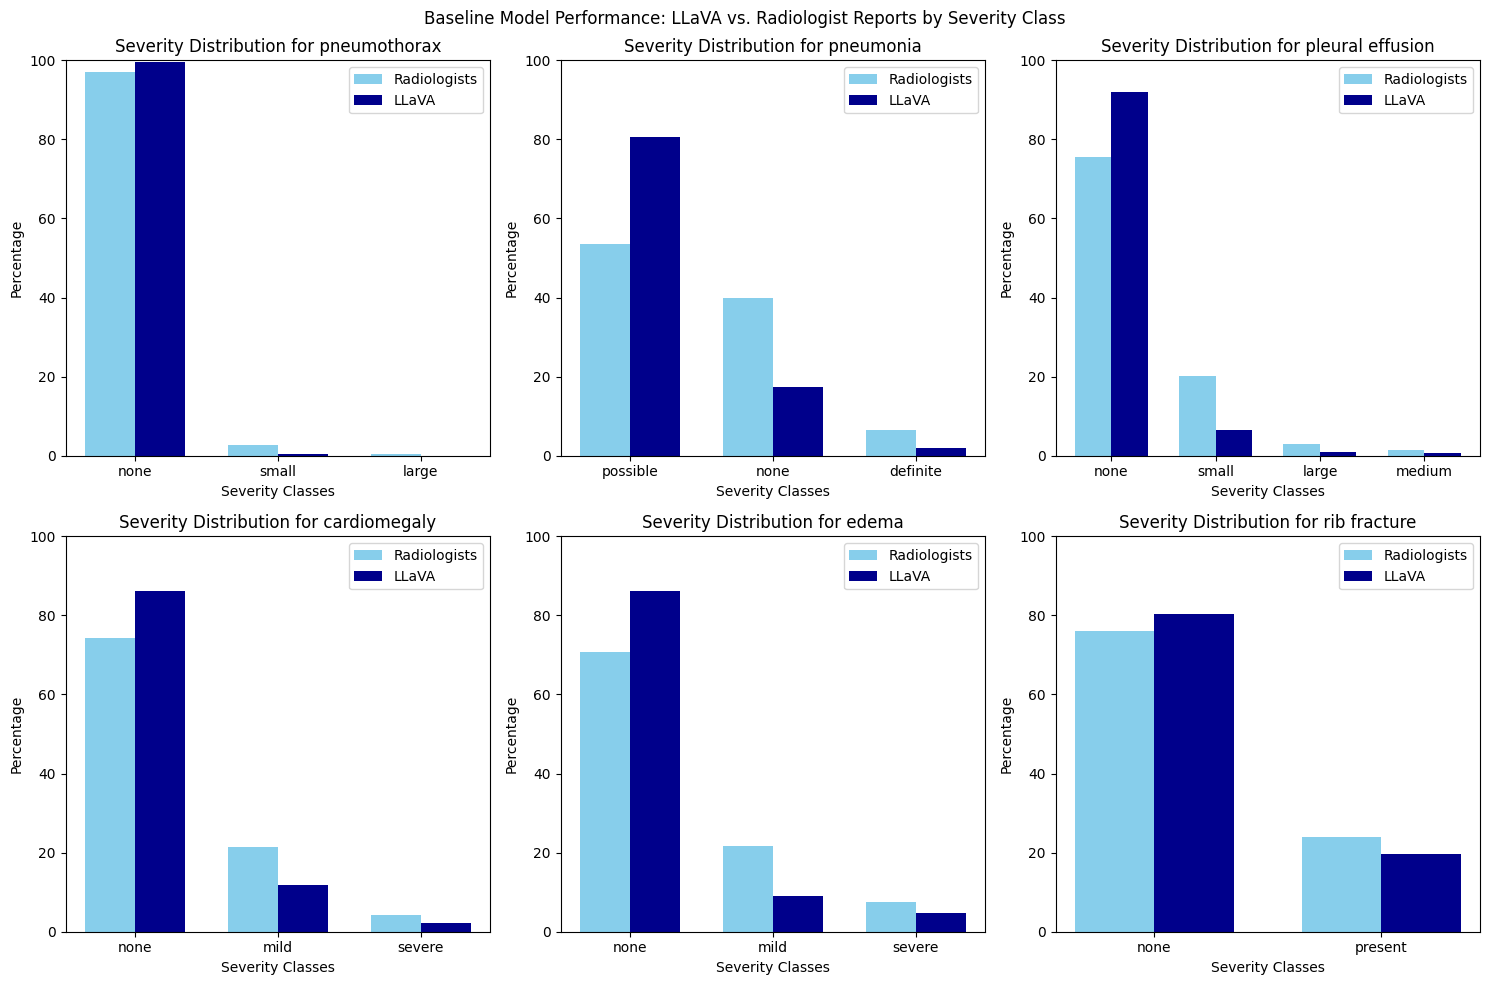

In [49]:
label_cols = [f'label_{key}' for key in keys]
output_cols = [f'output_{key}' for key in keys]

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i, (label_col, output_col) in enumerate(zip(label_cols, output_cols)):
    label_value_counts_percentage = eval_df[label_col].value_counts(normalize=True) * 100
    output_value_counts_percentage = eval_df[output_col].value_counts(normalize=True) * 100

    index = np.arange(len(label_value_counts_percentage))
    bar_width = 0.35
    
    axs[i].bar(index - bar_width/2, label_value_counts_percentage, bar_width, label='Radiologists', color='skyblue')
    axs[i].bar(index + bar_width/2, output_value_counts_percentage, bar_width, label='LLaVA', color='darkblue')
    
    axs[i].set_title(f'Severity Distribution for {keys[i]}')
    axs[i].set_ylabel('Percentage')
    axs[i].set_xlabel('Severity Classes')
    axs[i].set_xticks(index)
    axs[i].set_xticklabels(label_value_counts_percentage.index, rotation=0)
    axs[i].set_ylim(0, 100)
    axs[i].legend()

plt.suptitle('Baseline Model Performance: LLaVA vs. Radiologist Reports by Severity Class')
plt.tight_layout()
plt.savefig('model1_comparison_plot.png')
plt.show()

In [206]:
score_dict = {}
for disease in keys:
    score = (eval_df[f'label_{disease}'] == eval_df[f'output_{disease}']).mean()
    score_dict[disease] = score
    print(f'{disease}: {score}')

pneumothorax: 0.9663483401546157
pneumonia: 0.4242837653478854
pleural effusion: 0.707594361073215
cardiomegaly: 0.6834924965893588
edema: 0.6412005457025921
rib fracture: 0.6662119145065939


In [211]:
occurrence_dict = {}
for disease in keys:
    ratio = df['label'].str.lower().str.contains(disease).mean()
    occurrence_dict[disease] = ratio
    print(f'{disease}: {ratio}')

pneumothorax: 0.09777171441564347
pneumonia: 0.1341518872214643
pleural effusion: 0.22692132787630742
cardiomegaly: 0.0814006366530241
edema: 0.3160527512505684
rib fracture: 0.008185538881309686


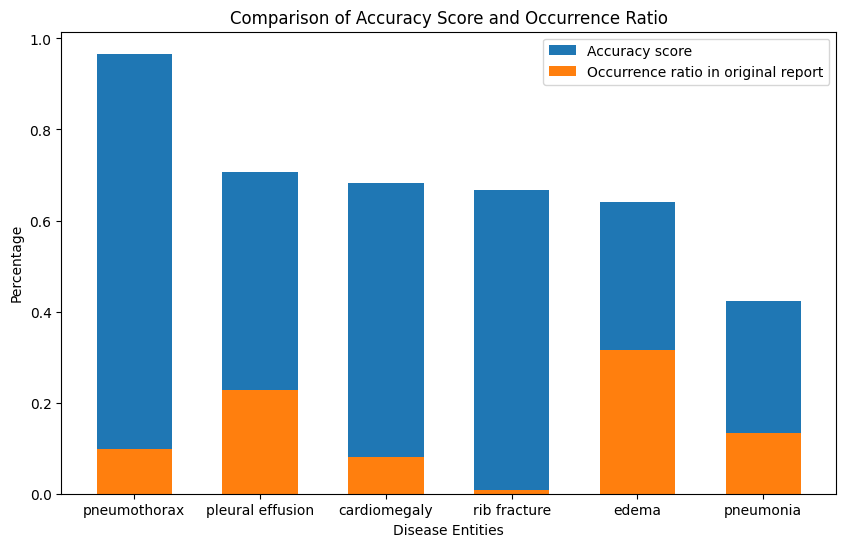

In [227]:
sorted_keys = sorted(score_dict, key=score_dict.get, reverse=True)
sorted_scores = [score_dict[key] for key in sorted_keys]
sorted_occurrences = [occurrence_dict[key] for key in sorted_keys]

plt.figure(figsize=(10, 6))
plt.title('Comparison of Accuracy Score and Occurrence Ratio')
plt.xlabel('Disease Entities')
plt.ylabel('Percentage')
plt.bar(sorted_keys, sorted_scores, width=0.6, label='Accuracy score')
plt.bar(sorted_keys, sorted_occurrences, width=0.6, label='Occurrence ratio in original report')
plt.legend()

# plt.savefig('accuracy_occurrence_plot.png', dpi=300)